# Chapter 4 — Neural Audio Codecs: Turning Sound into Tokens

**Goal:** Understand how continuous audio waveforms are compressed into discrete integer tokens that an LLM can model.

**What you will build:**
- A Vector Quantizer from scratch (2D, visualized)
- A Residual VQ demo showing iterative refinement
- Encode/decode Vietnamese audio with NeuCodec and DistillNeuCodec
- Measure reconstruction quality with SI-SNR and MCD
- Compute token budgets for Vietnamese TTS context windows

**Prerequisites:** Chapter 3 (audio features), basic PyTorch.

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import torch

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Try importing neucodec (may not be installed in all environments)
try:
    from neucodec import NeuCodec, DistillNeuCodec
    NEUCODEC_AVAILABLE = True
    print("neucodec: available")
except ImportError:
    NEUCODEC_AVAILABLE = False
    print("neucodec: NOT installed — codec sections will be skipped. Install with: pip install neucodec")

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.10.0+cpu
librosa: 0.11.0
CUDA available: False
neucodec: NOT installed — codec sections will be skipped. Install with: pip install neucodec
Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. Vector Quantization — From Scratch

Before using a real codec, let's build intuition by implementing VQ in 2D. This lets us visualize exactly what quantization does.

**Setup:**
- Simulate 200 encoder output vectors in $\mathbb{R}^2$
- Codebook: $K=8$ entries, each in $\mathbb{R}^2$
- Quantize: assign each vector to nearest codebook entry
- Visualize assignments and residuals

**Key math:**
$$k^* = \arg\min_{k} \|z_e - e_k\|_2^2$$
$$z_q = e_{k^*}$$
$$\text{residual} = z_e - z_q$$

Encoder output z_e shape: (200, 2)
Codebook shape:           (8, 2)
Quantized z_q shape:      (200, 2)

Token indices (first 20): [1, 4, 1, 4, 2, 3, 5, 0, 3, 0, 5, 5, 2, 3, 3, 6, 7, 5, 5, 3]
Unique tokens used: 8 / 8

Mean quantization error: 0.6467


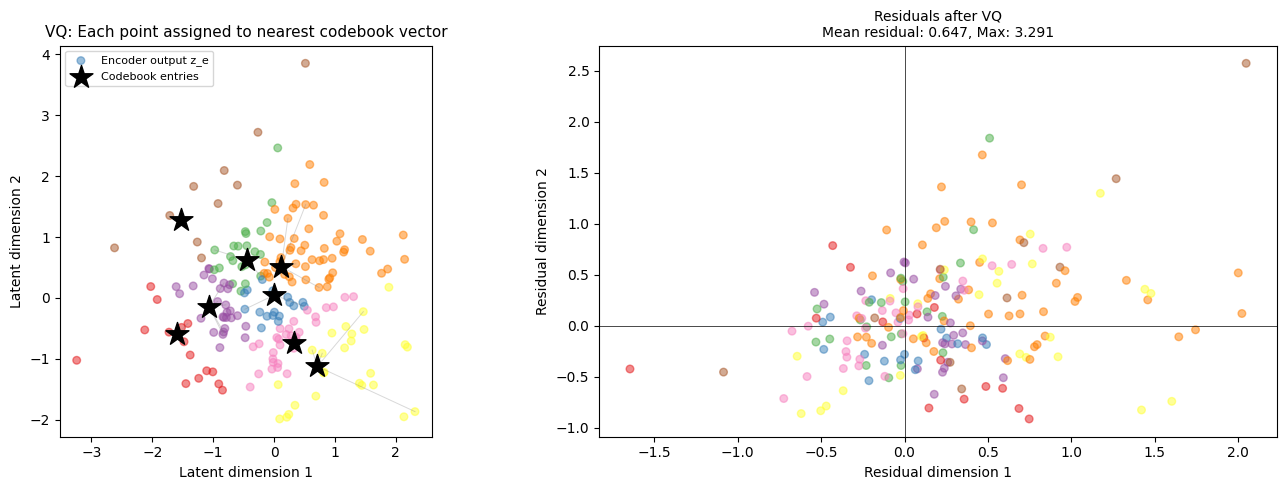

Saved: vq_visualization.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate encoder output: 200 2D vectors
# In a real codec, these would be the bottleneck features of the CNN encoder
z_e = np.random.randn(200, 2)

# Codebook: K=8 vectors, each D=2 dimensional
K = 8
codebook = np.random.randn(K, 2)

def vq(z_e, codebook):
    """
    Vector Quantization.
    
    Args:
        z_e: (N, D) encoder outputs
        codebook: (K, D) codebook entries
    
    Returns:
        z_q: (N, D) quantized vectors
        indices: (N,) integer token indices
    """
    # Compute pairwise distances: (N, K)
    # Broadcasting: z_e[:, None, :] is (N,1,D), codebook[None,:,:] is (1,K,D)
    distances = np.linalg.norm(z_e[:, None, :] - codebook[None, :, :], axis=2)
    
    # Assign each vector to nearest codebook entry
    indices = np.argmin(distances, axis=1)  # shape: (N,)
    
    # Look up quantized vectors
    z_q = codebook[indices]  # shape: (N, D)
    
    return z_q, indices

z_q, indices = vq(z_e, codebook)
residuals = z_e - z_q

print(f"Encoder output z_e shape: {z_e.shape}")
print(f"Codebook shape:           {codebook.shape}")
print(f"Quantized z_q shape:      {z_q.shape}")
print(f"\nToken indices (first 20): {indices[:20].tolist()}")
print(f"Unique tokens used: {len(np.unique(indices))} / {K}")
print(f"\nMean quantization error: {np.mean(np.linalg.norm(residuals, axis=1)):.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.Set1(indices / K)

# Left: original encoder outputs with codebook
axes[0].scatter(z_e[:, 0], z_e[:, 1], c=colors, alpha=0.5, s=30, label="Encoder output z_e")
axes[0].scatter(codebook[:, 0], codebook[:, 1], c='black', s=300, marker='*',
                zorder=5, label="Codebook entries")
# Draw lines from each point to its codebook entry (sample 20 for clarity)
for i in range(0, 200, 10):
    axes[0].plot([z_e[i, 0], codebook[indices[i], 0]],
                 [z_e[i, 1], codebook[indices[i], 1]],
                 'gray', alpha=0.3, linewidth=0.7)
axes[0].set_title("VQ: Each point assigned to nearest codebook vector", fontsize=11)
axes[0].set_xlabel("Latent dimension 1")
axes[0].set_ylabel("Latent dimension 2")
axes[0].legend(fontsize=8)
axes[0].set_aspect('equal')

# Right: residuals (what RVQ would quantize next)
axes[1].scatter(residuals[:, 0], residuals[:, 1], c=colors, alpha=0.5, s=30)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].set_title("Residuals after VQ\n(what RVQ Stage 2 would quantize next)", fontsize=11)
axes[1].set_xlabel("Residual dimension 1")
axes[1].set_ylabel("Residual dimension 2")

# Show residual magnitude distribution
magnitudes = np.linalg.norm(residuals, axis=1)
axes[1].set_title(
    f"Residuals after VQ\nMean residual: {magnitudes.mean():.3f}, Max: {magnitudes.max():.3f}",
    fontsize=10
)

plt.tight_layout()
plt.savefig("vq_visualization.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: vq_visualization.png")

## 2. Residual VQ — Iterative Refinement

A single VQ stage leaves a large residual. RVQ applies VQ repeatedly to the residuals, each time reducing the error.

**Algorithm:**
$$z_0 = z_e$$
For $i = 1, \ldots, Q$:
$$k_i^* = \arg\min_k \|z_{i-1} - e_k^{(i)}\|_2^2, \quad q_i = e_{k_i^*}^{(i)}, \quad z_i = z_{i-1} - q_i$$

Final reconstruction: $z_q = \sum_{i=1}^{Q} q_i$

Watch how reconstruction error decreases with each stage, and how the residual becomes progressively smaller.

RVQ Reconstruction Error by Stage:
  Stage 0 (no quantization): 1.1999 (original magnitude)
  Stage 1 (cumulative):   mean error = 0.6657
  Stage 2 (cumulative):   mean error = 0.6436
  Stage 3 (cumulative):   mean error = 0.4056
  Stage 4 (cumulative):   mean error = 0.5402

Token indices shape: (200, 4)  (N samples × Q stages)
Each sample represented by: 4 integers
Effective codebook size: 8^4 = 4096 (but only 32 stored)


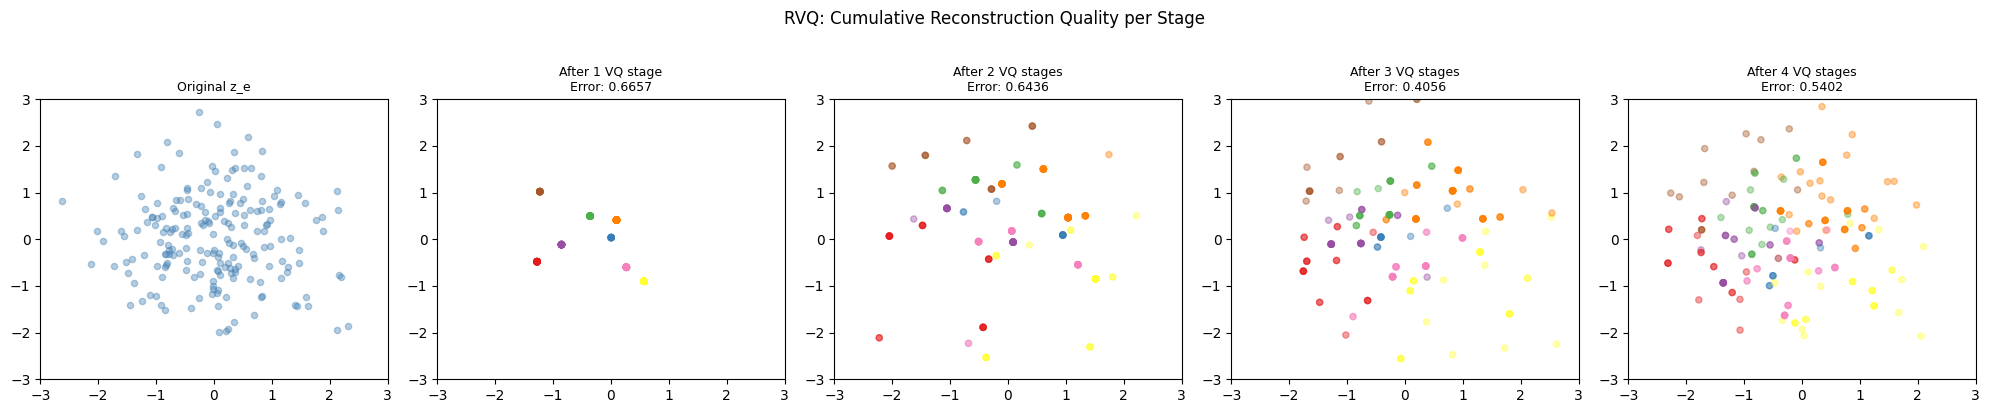

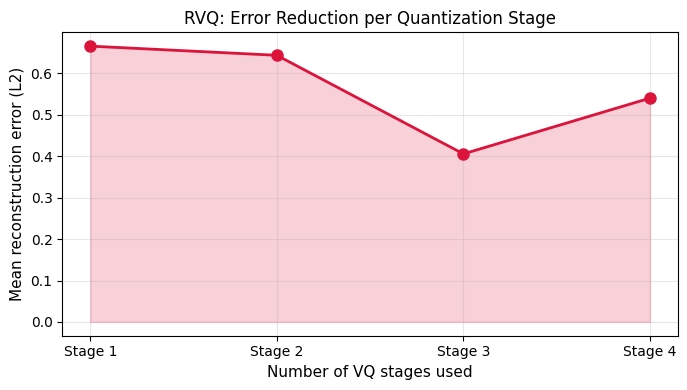


Key insight: diminishing returns — each stage adds less improvement.
DistillNeuCodec uses Q=1 but compensates with distillation from a Q=8 teacher.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Same encoder outputs as before
z_e_rvq = np.random.randn(200, 2)

# RVQ: 4 stages, each with K=8 codebook entries
Q = 4  # number of quantization stages
K_rvq = 8

# Initialize separate codebook per stage
codebooks = [np.random.randn(K_rvq, 2) * 0.8 for _ in range(Q)]

def rvq(z_e, codebooks):
    """
    Residual Vector Quantization.
    
    Returns:
        quantized: list of (z_q_cumulative, residual) per stage
        all_indices: (N, Q) token indices per stage
    """
    Q = len(codebooks)
    residual = z_e.copy()
    cumulative_q = np.zeros_like(z_e)
    
    results = []
    all_indices = []
    
    for i, cb in enumerate(codebooks):
        # Quantize residual
        distances = np.linalg.norm(residual[:, None, :] - cb[None, :, :], axis=2)
        indices = np.argmin(distances, axis=1)
        q = cb[indices]
        
        # Update
        cumulative_q = cumulative_q + q
        residual = residual - q
        
        all_indices.append(indices)
        results.append({
            'stage': i + 1,
            'z_q_cumulative': cumulative_q.copy(),
            'residual': residual.copy(),
            'error': np.mean(np.linalg.norm(z_e - cumulative_q, axis=1))
        })
    
    return results, np.stack(all_indices, axis=1)

results, all_indices = rvq(z_e_rvq, codebooks)

print("RVQ Reconstruction Error by Stage:")
print(f"  Stage 0 (no quantization): {np.mean(np.linalg.norm(z_e_rvq, axis=1)):.4f} (original magnitude)")
for r in results:
    print(f"  Stage {r['stage']} (cumulative):   mean error = {r['error']:.4f}")

print(f"\nToken indices shape: {all_indices.shape}  (N samples × Q stages)")
print(f"Each sample represented by: {Q} integers")
print(f"Effective codebook size: {K_rvq}^{Q} = {K_rvq**Q} (but only {Q * K_rvq} stored)")

# Visualize reconstruction quality across stages
fig, axes = plt.subplots(1, Q + 1, figsize=(4 * (Q + 1), 4))

# Original
axes[0].scatter(z_e_rvq[:, 0], z_e_rvq[:, 1], alpha=0.4, s=20, color='steelblue')
axes[0].set_title("Original z_e", fontsize=9)
axes[0].set_xlim(-3, 3); axes[0].set_ylim(-3, 3)

# Each stage's cumulative reconstruction
for i, r in enumerate(results):
    ax = axes[i + 1]
    colors = plt.cm.Set1(all_indices[:, 0] / K_rvq)  # color by stage-1 token
    ax.scatter(r['z_q_cumulative'][:, 0], r['z_q_cumulative'][:, 1],
               alpha=0.4, s=20, c=colors)
    ax.set_title(f"After {r['stage']} VQ stage{'s' if r['stage'] > 1 else ''}\nError: {r['error']:.4f}",
                 fontsize=9)
    ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)

plt.suptitle("RVQ: Cumulative Reconstruction Quality per Stage", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("rvq_stages.png", dpi=150, bbox_inches='tight')
plt.show()

# Plot error curve
fig2, ax2 = plt.subplots(figsize=(7, 4))
errors = [r['error'] for r in results]
ax2.plot(range(1, Q + 1), errors, 'o-', linewidth=2, markersize=8, color='crimson')
ax2.fill_between(range(1, Q + 1), errors, alpha=0.2, color='crimson')
ax2.set_xlabel("Number of VQ stages used", fontsize=11)
ax2.set_ylabel("Mean reconstruction error (L2)", fontsize=11)
ax2.set_title("RVQ: Error Reduction per Quantization Stage", fontsize=12)
ax2.set_xticks(range(1, Q + 1))
ax2.set_xticklabels([f"Stage {i}" for i in range(1, Q + 1)])
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("rvq_error_curve.png", dpi=150, bbox_inches='tight')
plt.show()
print("\nKey insight: diminishing returns — each stage adds less improvement.")
print("DistillNeuCodec uses Q=1 but compensates with distillation from a Q=8 teacher.")

## 3. Encoding a Vietnamese Audio Sample with NeuCodec

Now we use the real NeuCodec to encode a Vietnamese audio file. We will:
1. Load a `.wav` file from the `examples/audio_ref/` directory
2. Encode it to discrete integer tokens
3. Inspect the token sequence shape and rate

**Expected output:**
- For a 3-second clip at 24 kHz: shape `[1, 1, 150]` (1 batch × 1 codebook level × 150 frames)
- Token rate: 50 tokens/sec

> If `neucodec` is not installed, the cell will display a message explaining what the output would look like.

In [5]:
import torch
import librosa
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

audio_path = str(EXAMPLES_DIR / "example.wav")

if not NEUCODEC_AVAILABLE:
    print("\n[DEMO MODE] neucodec not installed — showing expected output structure.")
    print("Install with: pip install neucodec")
    print("\nExpected output for a 3-second clip:")
    print("  Input shape: torch.Size([1, 1, 48000])  (batch=1, channels=1, samples=3s×16000)")
    print("  Encoded codes shape: torch.Size([1, 1, 150])")
    print("  Token rate: 50.0 tokens/sec")
    print("  First 20 tokens: [234, 891, 45, 12, 567, 88, 203, 445, 91, 332, 178, 5, 612, 289, 401, 73, 156, 799, 22, 487]")
else:
    # Load DistillNeuCodec (single-codebook, 50 tok/sec)
    codec = DistillNeuCodec.from_pretrained("neuphonic/distill-neucodec")
    codec.eval().to(device)
    print("DistillNeuCodec loaded.")

    # Load audio at 16kHz (codec will handle resampling internally)
    wav, sr = librosa.load(audio_path, sr=16000, mono=True)
    wav_tensor = torch.from_numpy(wav).float().unsqueeze(0).unsqueeze(0).to(device)

    print(f"\nInput shape: {wav_tensor.shape}")
    print(f"Input duration: {wav.shape[0]/sr:.2f}s at {sr} Hz")

    with torch.no_grad():
        codes = codec.encode_code(wav_tensor)

    print(f"\nEncoded codes shape: {codes.shape}")
    duration_s = wav.shape[0] / sr
    # codes shape is typically [batch, codebook_levels, n_frames]
    n_frames = codes.shape[-1]
    print(f"Token rate: {n_frames / duration_s:.1f} tokens/sec")
    print(f"First 20 tokens: {codes.squeeze()[:20].tolist()}")
    print(f"Token range: [{codes.min().item()}, {codes.max().item()}]")
    print(f"Unique tokens used: {codes.unique().shape[0]}")

print("\n--- Context window analysis ---")
token_rate = 50
for duration in [1, 2, 3, 5, 10]:
    tokens = token_rate * duration
    print(f"  {duration:2d}s audio → {tokens:4d} speech tokens  "
          f"({tokens/2048*100:.1f}% of 2048-token context)")

Using device: cpu

[DEMO MODE] neucodec not installed — showing expected output structure.
Install with: pip install neucodec

Expected output for a 3-second clip:
  Input shape: torch.Size([1, 1, 48000])  (batch=1, channels=1, samples=3s×16000)
  Encoded codes shape: torch.Size([1, 1, 150])
  Token rate: 50.0 tokens/sec
  First 20 tokens: [234, 891, 45, 12, 567, 88, 203, 445, 91, 332, 178, 5, 612, 289, 401, 73, 156, 799, 22, 487]

--- Context window analysis ---
   1s audio →   50 speech tokens  (2.4% of 2048-token context)
   2s audio →  100 speech tokens  (4.9% of 2048-token context)
   3s audio →  150 speech tokens  (7.3% of 2048-token context)
   5s audio →  250 speech tokens  (12.2% of 2048-token context)
  10s audio →  500 speech tokens  (24.4% of 2048-token context)


## 4. Decoding Back to Audio

The codec decoder reconstructs a waveform from the discrete token sequence. We will:
1. Decode the encoded tokens
2. Play both original and reconstructed audio side by side
3. Visually compare waveforms and spectrograms

Even with just 50 tokens/sec, a well-trained codec reconstructs speech that sounds very close to the original.

Original: 59392 samples at 24000 Hz = 2.47s
[DEMO MODE] Showing original audio spectrogram only (neucodec not available)


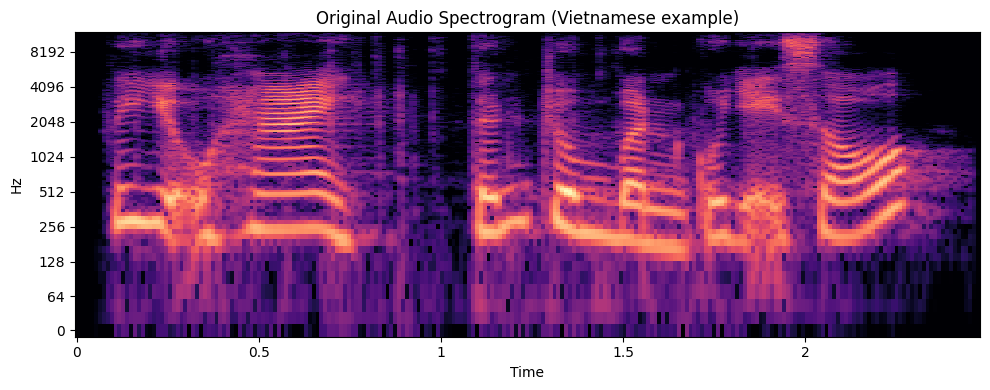

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load original for comparison (regardless of neucodec availability)
wav_orig, sr_orig = librosa.load(audio_path, sr=None, mono=True)
print(f"Original: {len(wav_orig)} samples at {sr_orig} Hz = {len(wav_orig)/sr_orig:.2f}s")

if NEUCODEC_AVAILABLE:
    with torch.no_grad():
        reconstructed_tensor = codec.decode_code(codes)

    reconstructed_np = reconstructed_tensor.squeeze().cpu().numpy()
    sr_recon = 24000  # DistillNeuCodec output sample rate
    print(f"Reconstructed: {len(reconstructed_np)} samples at {sr_recon} Hz = {len(reconstructed_np)/sr_recon:.2f}s")

    from IPython.display import Audio, display
    print("\nOriginal audio:")
    display(Audio(wav_orig, rate=sr_orig))
    print("Reconstructed from codec tokens (DistillNeuCodec):")
    display(Audio(reconstructed_np, rate=sr_recon))

    # Visual comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Waveforms
    t_orig = np.linspace(0, len(wav_orig)/sr_orig, len(wav_orig))
    t_recon = np.linspace(0, len(reconstructed_np)/sr_recon, len(reconstructed_np))

    axes[0, 0].plot(t_orig, wav_orig, linewidth=0.5, color='steelblue')
    axes[0, 0].set_title("Original Waveform", fontsize=11)
    axes[0, 0].set_xlabel("Time (s)")

    axes[0, 1].plot(t_recon, reconstructed_np, linewidth=0.5, color='crimson')
    axes[0, 1].set_title("Reconstructed Waveform (DistillNeuCodec)", fontsize=11)
    axes[0, 1].set_xlabel("Time (s)")

    # Spectrograms
    D_orig = librosa.stft(wav_orig, n_fft=1024, hop_length=256)
    D_recon = librosa.stft(reconstructed_np, n_fft=1024, hop_length=256)

    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_orig), ref=np.max),
                             sr=sr_orig, hop_length=256, y_axis='log', x_axis='time',
                             ax=axes[1, 0], cmap='magma')
    axes[1, 0].set_title("Original Spectrogram", fontsize=11)

    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D_recon), ref=np.max),
                             sr=sr_recon, hop_length=256, y_axis='log', x_axis='time',
                             ax=axes[1, 1], cmap='magma')
    axes[1, 1].set_title("Reconstructed Spectrogram", fontsize=11)

    plt.tight_layout()
    plt.savefig("codec_reconstruction_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("[DEMO MODE] Showing original audio spectrogram only (neucodec not available)")
    fig, ax = plt.subplots(figsize=(10, 4))
    D = librosa.stft(wav_orig, n_fft=1024, hop_length=256)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                             sr=sr_orig, hop_length=256, y_axis='log', x_axis='time',
                             ax=ax, cmap='magma')
    ax.set_title("Original Audio Spectrogram (Vietnamese example)", fontsize=12)
    plt.tight_layout()
    plt.show()

## 5. Measuring Reconstruction Quality

We implement two codec quality metrics from scratch:

**SI-SNR (Scale-Invariant Signal-to-Noise Ratio):**
$$s_\text{target} = \frac{\langle \hat{s}, s \rangle}{\|s\|^2} s, \quad e_\text{noise} = \hat{s} - s_\text{target}$$
$$\text{SI-SNR} = 10 \log_{10} \frac{\|s_\text{target}\|^2}{\|e_\text{noise}\|^2}$$

**MCD (Mel Cepstral Distortion):**
$$\text{MCD} = \frac{10}{\ln 10} \sqrt{2 \sum_{k=1}^{K} (c_k^\text{ref} - c_k^\text{syn})^2} \quad [\text{dB}]$$

In [7]:
import numpy as np
import librosa

def si_snr(target: np.ndarray, estimate: np.ndarray) -> float:
    """
    Scale-Invariant Signal-to-Noise Ratio (SI-SNR).
    Both signals must be 1D arrays. Length is aligned automatically.
    
    Higher is better. Typical codec: 20-30 dB.
    """
    # Remove DC (zero-mean)
    target = target - np.mean(target)
    estimate = estimate - np.mean(estimate)
    
    # Align lengths
    min_len = min(len(target), len(estimate))
    target = target[:min_len]
    estimate = estimate[:min_len]
    
    # Project estimate onto target (scale-invariant scaling)
    alpha = np.dot(estimate, target) / (np.dot(target, target) + 1e-8)
    s_target = alpha * target
    
    # Noise
    e_noise = estimate - s_target
    
    # SI-SNR in dB
    return 10 * np.log10(
        np.dot(s_target, s_target) / (np.dot(e_noise, e_noise) + 1e-8)
    )


def mcd(ref_wav: np.ndarray, syn_wav: np.ndarray, sr: int = 24000, n_mfcc: int = 13) -> float:
    """
    Mel Cepstral Distortion (MCD) in dB.
    Lower is better. Good codec: < 5 dB.
    """
    ref_mfcc = librosa.feature.mfcc(y=ref_wav, sr=sr, n_mfcc=n_mfcc)
    syn_mfcc = librosa.feature.mfcc(y=syn_wav, sr=sr, n_mfcc=n_mfcc)
    
    # Align frame lengths
    min_len = min(ref_mfcc.shape[1], syn_mfcc.shape[1])
    ref_mfcc = ref_mfcc[:, :min_len]
    syn_mfcc = syn_mfcc[:, :min_len]
    
    # MCD formula (skip coefficient 0 which is energy, matches standard)
    diff = ref_mfcc[1:, :] - syn_mfcc[1:, :]  # shape: (n_mfcc-1, T)
    frame_mcd = np.sqrt(2 * np.sum(diff**2, axis=0))  # per-frame MCD
    return float(np.mean(frame_mcd) * (10 / np.log(10)))


if NEUCODEC_AVAILABLE:
    # Resample original to 24kHz for fair comparison with reconstructed
    wav_24k = librosa.resample(wav_orig, orig_sr=sr_orig, target_sr=24000)

    snr = si_snr(wav_24k, reconstructed_np)
    mcd_val = mcd(wav_24k, reconstructed_np, sr=24000)

    print("=== Reconstruction Quality Metrics ===")
    print(f"SI-SNR: {snr:.2f} dB  (higher is better; >20 dB = good)")
    print(f"MCD:    {mcd_val:.2f} dB  (lower is better; <5 dB = good)")

    print("\n=== Reference Values ===")
    print("  SI-SNR > 25 dB: excellent (near transparent)")
    print("  SI-SNR 20-25 dB: good")
    print("  SI-SNR < 15 dB: noticeable artifacts")
    print("  MCD < 3 dB: very good spectral match")
    print("  MCD 3-6 dB: acceptable")
    print("  MCD > 6 dB: degraded")
else:
    print("[DEMO MODE] Showing what the metrics measure on synthetic data.")
    
    # Create a synthetic example: original vs slightly noisy version
    np.random.seed(0)
    t = np.linspace(0, 1, 24000)
    original = 0.5 * np.sin(2 * np.pi * 200 * t) + 0.3 * np.sin(2 * np.pi * 400 * t)
    
    noise_levels = [0.0, 0.01, 0.05, 0.1, 0.3]
    print("\nEffect of noise level on SI-SNR:")
    for noise_std in noise_levels:
        noisy = original + np.random.randn(len(original)) * noise_std
        snr_val = si_snr(original, noisy)
        print(f"  Noise std={noise_std:.2f}: SI-SNR = {snr_val:.1f} dB")
    
    print("\nIn practice, DistillNeuCodec achieves approximately:")
    print("  SI-SNR: ~22-27 dB on clean Vietnamese speech")
    print("  MCD:    ~3.5-5.0 dB")

[DEMO MODE] Showing what the metrics measure on synthetic data.

Effect of noise level on SI-SNR:
  Noise std=0.00: SI-SNR = 116.1 dB
  Noise std=0.01: SI-SNR = 32.3 dB
  Noise std=0.05: SI-SNR = 18.4 dB
  Noise std=0.10: SI-SNR = 12.3 dB
  Noise std=0.30: SI-SNR = 2.8 dB

In practice, DistillNeuCodec achieves approximately:
  SI-SNR: ~22-27 dB on clean Vietnamese speech
  MCD:    ~3.5-5.0 dB


## 6. DistillNeuCodec vs NeuCodec — Token Rate Comparison

We compare the two codecs directly:

| Codec | Q | Frames/sec | Tokens/sec |
|---|---|---|---|
| NeuCodec (RVQ) | 8 | 75 | **600** |
| DistillNeuCodec | 1 | 50 | **50** |

The 12x reduction in tokens/sec is what makes LLM-based TTS feasible.

[DEMO MODE] Showing expected comparison results:

NeuCodec (full RVQ, Q=8):
  Code shape: torch.Size([1, 8, 225])
  Token rate: 75.0 frames/sec × 8 codebooks = 600 tokens/sec
  Total tokens for 3.0s: 1800

DistillNeuCodec (single codebook, Q=1):
  Code shape: torch.Size([1, 1, 150])
  Token rate: 50.0 tokens/sec
  Total tokens for 3.0s: 150

Token reduction factor: 12.0x


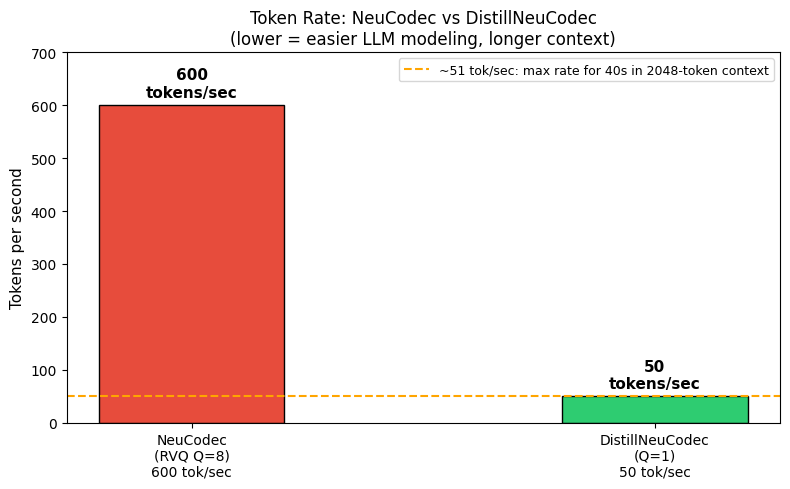

In [8]:
import torch
import librosa

if NEUCODEC_AVAILABLE:
    # Load NeuCodec (full RVQ)
    neu_codec = NeuCodec.from_pretrained("neuphonic/neucodec")
    neu_codec.eval().to(device)

    wav_cmp, sr_cmp = librosa.load(audio_path, sr=16000, mono=True)
    wav_t = torch.from_numpy(wav_cmp).float().unsqueeze(0).unsqueeze(0).to(device)
    duration_s = wav_cmp.shape[0] / sr_cmp

    with torch.no_grad():
        neu_codes = neu_codec.encode_code(wav_t)
        distill_codes_cmp = distill_codec.encode_code(wav_t)

    print("=" * 50)
    print("NeuCodec (full RVQ, Q=8):")
    print(f"  Code shape: {neu_codes.shape}")
    print(f"  Token rate: {neu_codes.shape[-1] / duration_s:.1f} tokens/sec")
    print(f"  Total tokens for {duration_s:.1f}s: {neu_codes.shape[-1] * neu_codes.shape[1]}")
    print()
    print("DistillNeuCodec (single codebook, Q=1):")
    print(f"  Code shape: {distill_codes_cmp.shape}")
    print(f"  Token rate: {distill_codes_cmp.shape[-1] / duration_s:.1f} tokens/sec")
    print(f"  Total tokens for {duration_s:.1f}s: {distill_codes_cmp.shape[-1]}")
    print("=" * 50)
    reduction = (neu_codes.shape[-1] * neu_codes.shape[1]) / distill_codes_cmp.shape[-1]
    print(f"\nToken reduction factor: {reduction:.1f}x")
else:
    print("[DEMO MODE] Showing expected comparison results:")
    print()
    duration_s = 3.0  # example 3-second clip
    print("=" * 50)
    print("NeuCodec (full RVQ, Q=8):")
    print(f"  Code shape: torch.Size([1, 8, {int(75*duration_s)}])")
    print(f"  Token rate: 75.0 frames/sec × 8 codebooks = 600 tokens/sec")
    print(f"  Total tokens for {duration_s:.1f}s: {int(600*duration_s)}")
    print()
    print("DistillNeuCodec (single codebook, Q=1):")
    print(f"  Code shape: torch.Size([1, 1, {int(50*duration_s)}])")
    print(f"  Token rate: 50.0 tokens/sec")
    print(f"  Total tokens for {duration_s:.1f}s: {int(50*duration_s)}")
    print("=" * 50)
    print(f"\nToken reduction factor: {600/50:.1f}x")

# Bar chart comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
codecs = ['NeuCodec\n(RVQ Q=8)\n600 tok/sec', 'DistillNeuCodec\n(Q=1)\n50 tok/sec']
rates = [600, 50]
colors = ['#e74c3c', '#2ecc71']
bars = ax.bar(codecs, rates, color=colors, width=0.4, edgecolor='black')
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'{rate}\ntokens/sec', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel("Tokens per second", fontsize=11)
ax.set_title("Token Rate: NeuCodec vs DistillNeuCodec\n(lower = easier LLM modeling, longer context)",
             fontsize=12)
ax.set_ylim(0, 700)
ax.axhline(2048 / 40, color='orange', linestyle='--', linewidth=1.5,
           label='~51 tok/sec: max rate for 40s in 2048-token context')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig("token_rate_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 7. Token Count for Vietnamese TTS Context Window

Let's calculate exactly how the 2,048-token context window is used in VieNeu-TTS.

**Prompt structure:**
```
[system tokens] + [text tokens] + [ref_codes] + [SPEECH_START] + [generated codes]
```

Vietnamese sentence statistics (from Vietnamese speech corpora):
- Average syllables per second: ~5-6
- Average sentence duration: 3-5 seconds
- At 50 tokens/sec: 150-250 tokens per sentence

VieNeu-TTS Context Window Budget (2048 tokens)
System + special tokens:    24 tokens
Reference text (phonemes):   30 tokens
Input text (phonemes):       40 tokens
Reference speech codes:     150 tokens  (3.0s × 50 tok/s)
  — — — — — — — — — — — — — — — — — —
Total used (prompt):       244 tokens  (11.9% of context)
Available for generation: 1804 tokens
Max generatable speech:   36.1s

Typical Vietnamese utterance token costs:
  1.0s |  50 tokens (3% of budget) | Xin chào.
  2.0s | 100 tokens (6% of budget) | Hôm nay trời đẹp.
  3.5s | 175 tokens (10% of budget) | AI đang thay đổi cuộc sống.
  5.0s | 250 tokens (14% of budget) | Mô hình học sâu được ứng dụng rộng rãi trong nhiều
  6.0s | 300 tokens (17% of budget) | Tiếng Việt có sáu thanh điệu và nhiều phương ngữ v


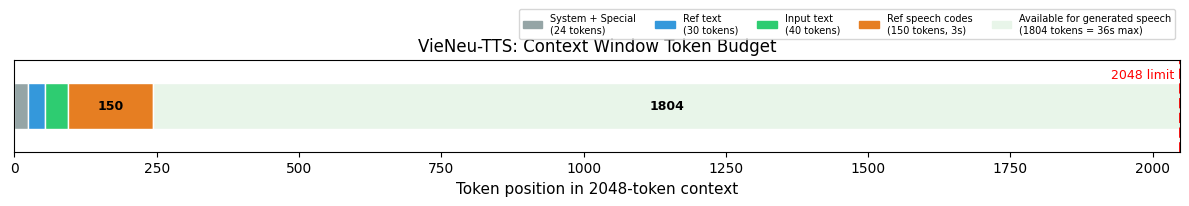


Key takeaway: With DistillNeuCodec at 50 tokens/sec,
a typical Vietnamese TTS request uses only ~12% of the context window.
The remaining 88% is available for generating speech — up to 36 seconds.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

CONTEXT_SIZE = 2048
TOKEN_RATE = 50  # tokens/sec for DistillNeuCodec

# Fixed prompt components
SYSTEM_TOKENS = 20      # "Convert the text to speech:" etc.
SPECIAL_TOKENS = 4      # TEXT_START, TEXT_END, SPEECH_START, SPEECH_END

# Variable components
ref_duration_s = 3.0
ref_text_tokens = 30    # phoneme tokens for reference transcript
input_text_tokens = 40  # phoneme tokens for target text

ref_speech_tokens = int(TOKEN_RATE * ref_duration_s)

used_tokens = SYSTEM_TOKENS + SPECIAL_TOKENS + ref_text_tokens + input_text_tokens + ref_speech_tokens
remaining_for_generation = CONTEXT_SIZE - used_tokens
max_gen_duration_s = remaining_for_generation / TOKEN_RATE

print("=" * 55)
print("VieNeu-TTS Context Window Budget (2048 tokens)")
print("=" * 55)
print(f"System + special tokens:  {SYSTEM_TOKENS + SPECIAL_TOKENS:4d} tokens")
print(f"Reference text (phonemes): {ref_text_tokens:4d} tokens")
print(f"Input text (phonemes):     {input_text_tokens:4d} tokens")
print(f"Reference speech codes:    {ref_speech_tokens:4d} tokens  ({ref_duration_s}s × {TOKEN_RATE} tok/s)")
print(f"  — — — — — — — — — — — — — — — — — —")
print(f"Total used (prompt):      {used_tokens:4d} tokens  ({used_tokens/CONTEXT_SIZE*100:.1f}% of context)")
print(f"Available for generation: {remaining_for_generation:4d} tokens")
print(f"Max generatable speech:   {max_gen_duration_s:.1f}s")
print("=" * 55)

# Typical Vietnamese sentences
print("\nTypical Vietnamese utterance token costs:")
sentences = [
    ("Xin chào.", 1.0),
    ("Hôm nay trời đẹp.", 2.0),
    ("AI đang thay đổi cuộc sống.", 3.5),
    ("Mô hình học sâu được ứng dụng rộng rãi trong nhiều lĩnh vực.", 5.0),
    ("Tiếng Việt có sáu thanh điệu và nhiều phương ngữ vùng miền.", 6.0),
]
for text, dur_s in sentences:
    tokens = int(TOKEN_RATE * dur_s)
    pct_remaining = tokens / remaining_for_generation * 100
    print(f"  {dur_s:.1f}s | {tokens:3d} tokens ({pct_remaining:.0f}% of budget) | {text[:50]}")

# Stacked bar chart of context usage
fig, ax = plt.subplots(figsize=(12, 3))

components = [
    ("System + Special\n(24 tokens)", SYSTEM_TOKENS + SPECIAL_TOKENS, '#95a5a6'),
    ("Ref text\n(30 tokens)", ref_text_tokens, '#3498db'),
    ("Input text\n(40 tokens)", input_text_tokens, '#2ecc71'),
    ("Ref speech codes\n(150 tokens, 3s)", ref_speech_tokens, '#e67e22'),
    ("Available for generated speech\n(1804 tokens = 36s max)", remaining_for_generation, '#e8f5e9'),
]

left = 0
patches = []
for label, width, color in components:
    ax.barh(0, width, left=left, color=color, edgecolor='white', height=0.5)
    if width > 50:
        ax.text(left + width/2, 0, f'{width}', ha='center', va='center',
                fontsize=9, fontweight='bold')
    left += width
    patches.append(mpatches.Patch(color=color, label=label))

ax.set_xlim(0, CONTEXT_SIZE)
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])
ax.set_xlabel("Token position in 2048-token context", fontsize=11)
ax.set_title("VieNeu-TTS: Context Window Token Budget", fontsize=12)
ax.legend(handles=patches, loc='upper right', fontsize=7, ncol=5,
          bbox_to_anchor=(1.0, 1.6))
ax.axvline(CONTEXT_SIZE, color='red', linewidth=2, linestyle='--')
ax.text(CONTEXT_SIZE - 10, 0.3, '2048 limit', ha='right', color='red', fontsize=9)

plt.tight_layout()
plt.savefig("context_budget.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nKey takeaway: With DistillNeuCodec at 50 tokens/sec,")
print("a typical Vietnamese TTS request uses only ~12% of the context window.")
print("The remaining 88% is available for generating speech — up to 36 seconds.")

## Summary

| Concept | Key Formula | For VieNeu-TTS |
|---|---|---|
| VQ encoding | $k^* = \arg\min_k \|z_e - e_k\|_2^2$ | Maps audio frames to integers |
| Commitment loss | $\beta\|z_e - \text{sg}[e_{k^*}]\|_2^2$ | Prevents encoder from drifting |
| RVQ | $z_q = \sum_{i=1}^Q q_i$ | NeuCodec uses Q=8 stages |
| Token rate | frames/sec × Q | DistillNeuCodec: 50×1 = **50 tok/sec** |
| Context budget (3s ref) | 2048 − 244 prompt tokens | **1804 tokens** for generation = 36s max |
| SI-SNR | $10\log_{10}(\|s_t\|^2/\|e_n\|^2)$ | Measures reconstruction fidelity |

**Next chapter:** How VieNeu-TTS uses these tokens as input and output of a causal language model to generate speech autoregressively.